In [1]:
import sys
sys.path.append('..')

from data.tile_stitcher import stitch_predictions


In [2]:
# ckpt = '2410/Hagen-joint_indi-l1/36'
# ckpt = '2502/Hagen-joint_indi-l1/57'
# ckpt  = '2412/HT_LIF-joint_indi-l1/8'
# ckpt = '2501/COSEM_jrc-hela-joint_indi-l1/32'
# ckpt = '2502/COSEM_jrc-hela-joint_indi-l1/13'
# ckpt = '2502/HT_LIF24-joint_indi-l1/60'
ckpt = '2502/Hagen-joint_indi-l1/57'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
num_epochs_normalization = 10
ckpt_time_predictor = None #'2502/Hagen-UnetClassifier-l2/3'#None #'2502/Hagen-UnetClassifier-l2/0'
time_predictor = None
mixing_t_ood = 0.5
mmse_count = 1

num_timesteps = 1
enable_real_input = False
infer_time = False

ckpt = ckpt.strip('/').strip(' ')
ckpt

'2502/Hagen-joint_indi-l1/57'

In [3]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        # best_files = [f for f in list_of_files if 'best_gen_' in f]
        # assert len(best_files) == 1,f'{best_files}'
        # best_file = best_files[0]  
        fname = latest_file
        return os.path.join(ckpt_dir,fname)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [4]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os
import torch

if ckpt_time_predictor is not None:
    time_pred_ckpt_fpath = os.path.join(training_rootdir, ckpt_time_predictor)

    time_pred_opt = load_config(time_pred_ckpt_fpath)
    time_pred_model_opt = time_pred_opt['model']
    time_predictor = TimePredictor(
        in_channel=time_pred_model_opt['unet']['in_channel'],
        out_channel=time_pred_model_opt['unet']['out_channel'],
        norm_groups=time_pred_model_opt['unet']['norm_groups'],
        inner_channel=time_pred_model_opt['unet']['inner_channel'],
        channel_mults=time_pred_model_opt['unet']['channel_multiplier'],
        attn_res=time_pred_model_opt['unet']['attn_res'],
        res_blocks=time_pred_model_opt['unet']['res_blocks'],
        dropout=time_pred_model_opt['unet']['dropout'],
        image_size=time_pred_opt['datasets']['patch_size'],
        )
    
    time_predictor = time_predictor.cuda()
    time_predictor.load_state_dict(torch.load(os.path.join(time_pred_ckpt_fpath,'best_time_predictor.pth')), strict=True)
    print('Loaded time predictor from', time_pred_ckpt_fpath)


In [5]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
# opt['path']['resume_state'] = os.path.join(os.path.dirname(opt['path']['resume_state']),'I110000_E1375')
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
if opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('val_jrc_hela','test_jrc_hela')

elif opt['datasets']['train']['name'] == 'hagen':
    opt['datasets']['val']['datapath'] = {
    'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
    'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
    }
elif opt['datasets']['train']['name'] in ['HT_LIF24','HT_LIF']:
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val','/test')


/group/jug/ashesh/training/diffsplit/2502/Hagen-joint_indi-l1/57/checkpoint/I450000_E2813


In [6]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if enable_real_input:
    opt['datasets']['train']['real_input_fraction'] = 1.0
    opt['datasets']['val']['real_input_fraction'] = 1.0

opt['datasets']['normalize_channels'] = False

In [7]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

HARDCODED upperclip to 1993. Disable it if not needed !!!
Computing mean and std for normalization
[SplitDataset] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False InpFrmNormTar
HARDCODED upperclip to 1993. Disable it if not needed !!!
[TilingDataset] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False InpFrmNormTar
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[JointIndi]: w_input_loss: 0.1 
Scheduler set to ReduceLROnPlateau with patience:  100

--------------------------------------------------
Number of trainable parameters: 4.88M
--------------------------------------------------



In [8]:
from split import get_xt_normalizer
val_set.set_random_patching(True)
xt_normalizer1, xt_normalizer2 = get_xt_normalizer(val_set,opt['datasets']['train'], num_bins=100, 
                                                   num_epochs=num_epochs_normalization)
val_set.set_random_patching(False)

Random patching set to True


  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:24<00:00,  2.58it/s]

Random patching set to False


In [9]:
xt_normalizer1.data_mean, xt_normalizer1.data_std

(tensor([351.9249, 352.8487, 353.0584, 347.1727, 354.1439, 351.3501, 341.8943,
         336.8644, 340.1579, 346.2899, 340.1096, 340.5673, 335.9407, 335.4193,
         336.2169, 336.9245, 333.6932, 325.6116, 331.5024, 329.5376, 328.5738,
         327.1276, 327.3480, 324.1697, 321.4510, 326.8359, 320.4384, 316.4532,
         317.7633, 318.5818, 316.8343, 311.7497, 310.5932, 312.4433, 306.1558,
         308.5730, 303.6867, 304.2165, 307.0417, 299.0127, 300.2183, 293.5105,
         299.8503, 296.0499, 292.0673, 293.5378, 297.1041, 290.9497, 289.9300,
         294.3994, 288.5185, 288.2661, 282.4411, 283.7916, 282.9603, 285.9765,
         280.3327, 278.2195, 277.6270, 278.5399, 276.3031, 275.8742, 273.4306,
         272.0454, 267.8155, 270.0949, 265.0422, 265.8578, 265.4662, 259.9642,
         265.9255, 258.8494, 259.6585, 258.9771, 259.0944, 258.0886, 252.1837,
         254.7496, 249.8469, 250.6436, 246.3207, 247.2092, 248.7766, 245.9574,
         246.3283, 244.6435, 241.3378, 240.6026, 240

In [10]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd



In [11]:
import numpy as np
import random

def get_input_dict(data_dict):
    if opt['datasets']['train']['name'] in ['HT_LIF', 'HT_LIF24']:
        diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
    # elif opt['datasets']['train']['name'] == 'Hagen':
    #     diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
    elif opt['datasets']['train']['name'] in ['Hagen','COSEM_jrc-hela']:
        if enable_real_input:
            assert 'input' in data_dict and data_dict['input'].std() > 0, 'Input is not available'
            diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
        else:
            diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
            inp = diffusion_data['input']
            diffusion_data['input'] = xt_normalizer1.normalize(inp, torch.Tensor([0.5]*len(inp)), update=False)
        
    return diffusion_data

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

norm_dict = val_set.get_input_target_normalization_dict()
nimgs = 6
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for batch_data in dloader:
    break

diffusion_batch_input = get_input_dict(batch_data)

In [13]:
norm_dict.keys()

dict_keys(['mean_input', 'std_input', 'mean_channel', 'std_channel'])

In [14]:
def get_prediction(data_dict, infer_time=True):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict, infer_time=infer_time)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict, infer_time=True):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    t_float_start = 0.5
    if time_predictor is not None and infer_time:
        t_float_start = time_predictor(data_dict['input'].cuda())
        
    # NOTE: infer_time=False must be set for recent models.
    prediction = diffusion.netG.inference(data_dict['input'], infer_time=False, t_float_start=t_float_start).detach().cpu().numpy()
    input = data_dict['input'].cpu().numpy()
    target = data_dict['target'].cpu().numpy()

    
    # unnormalize 
    assert len(prediction.shape) == 4
    pred_unnorm = prediction * norm_dict['std_target'] + norm_dict['mean_target']
    target_unnorm = target * norm_dict['std_target'] + norm_dict['mean_target']
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [15]:
diffusion.set_new_noise_schedule(opt['model']['beta_schedule']['val'], schedule_phase='val')


In [16]:
import seaborn as sns
# show_hist = False
# if show_hist:
#     ncols = predictions.shape[-1]
#     _,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
#     for ch_idx in range(ncols):
#         sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
#         sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
#     plt.legend()
#     plt.tight_layout()

## Quantitative Evaluation using the classifier.
Here, we also inspect the effect of MMSE count.

In [17]:

if time_predictor is not None:
    t_pred1 = []
    t_pred2 = []
    with torch.no_grad():
        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
            inp_indi2 = data['target'][:1]*mixing_t_ood + data['target'][1:2]*(1-mixing_t_ood)
            inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
            inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
            # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
            norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
            norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)
            t1 = time_predictor(norm_inp1)
            t2 = time_predictor(norm_inp2)
            t_pred1.append(t1.item())
            t_pred2.append(t2.item())

    t_pred1_aggregated = np.mean(t_pred1) 
    t_pred2_aggregated = np.mean(t_pred2)
    print(t_pred1_aggregated, t_pred2_aggregated)
else:
    t_pred1_aggregated = None
    t_pred2_aggregated = None

In [18]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm
import numpy as np

def sanitize_t(t_val, eps = 1e-6):
    t_val = np.clip(t_val, 0+eps, 1-eps)
    return t_val

indi_model = diffusion.netG
psnr_dict_ood = defaultdict(list)
all_targets_ood = []
all_inputs_ood = []
eps = 1e-6

pred_t_1_arr = []
pred_t_2_arr = []
mmse_pred_bt_removed_arr = []
mmse_pred_dim_arr = []
with torch.no_grad():
    for mmse_idx in range(mmse_count):
        all_predictions_bt_removed = []
        all_predictions_dim_pred = []

        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
            inp_indi2 = data['target'][1:2]*(1-mixing_t_ood) + data['target'][:1]*mixing_t_ood

            inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
            inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
            # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
            norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
            norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)


            # prediction
            predicted_t1 = mixing_t_ood
            predicted_t2 = mixing_t_ood
            predicted_t1 = sanitize_t(predicted_t1)
            predicted_t2 = sanitize_t(predicted_t2)




            ch1_bt_removed = indi_model.indi1.inference(norm_inp1, num_timesteps=1, t_float_start=predicted_t1)
            ch2_bt_removed = indi_model.indi2.inference(norm_inp2,  num_timesteps=1, t_float_start=predicted_t2)
            
            ch2_dim_pred = indi_model.indi2.inference(norm_inp1, num_timesteps=1, t_float_start=1-predicted_t1)
            ch1_dim_pred = indi_model.indi1.inference(norm_inp2, num_timesteps=1, t_float_start=1-predicted_t2)

            if mmse_idx == 0:
                all_inputs_ood.append(np.concatenate([inp_indi1.cpu().numpy(), inp_indi2.cpu().numpy()], axis=1))
            pred_t_1_arr.append(predicted_t1)
            pred_t_2_arr.append(predicted_t2)

            
            pred_bt_removed = np.concatenate([ch1_bt_removed.cpu().numpy(), ch2_bt_removed.cpu().numpy()], axis=1)
            pred_dim_pred = np.concatenate([ch1_dim_pred.cpu().numpy(), ch2_dim_pred.cpu().numpy()], axis=1)
            # NOTE: unnormalize
            
            tar_unnorm = data['target']
            if mmse_idx == 0:
                all_targets_ood.append(tar_unnorm[None])
            
            all_predictions_bt_removed.append(pred_bt_removed)
            all_predictions_dim_pred.append(pred_dim_pred)

        all_predictions_bt_removed = np.concatenate(all_predictions_bt_removed, axis=0)
        all_predictions_dim_pred = np.concatenate(all_predictions_dim_pred, axis=0)

        mmse_pred_bt_removed_arr.append(all_predictions_bt_removed)
        mmse_pred_dim_arr.append(all_predictions_dim_pred)
    
all_targets_ood = np.concatenate(all_targets_ood, axis=0)
all_inputs_ood = np.concatenate(all_inputs_ood, axis=0)

pred_t_1_arr = np.array(pred_t_1_arr)
pred_t_2_arr = np.array(pred_t_2_arr)


100%|██████████| 490/490 [00:45<00:00, 10.68it/s]


In [19]:
mmse_pred_bt_removed = 0 
mmse_pred_dim_pred = 0
for i in range(mmse_count):
    mmse_pred_bt_removed += mmse_pred_bt_removed_arr[i]/mmse_count
    mmse_pred_dim_pred += mmse_pred_dim_arr[i]/mmse_count

In [20]:
from data.tile_stitcher import stitch_predictions

pred_bt_removed_stitched = stitch_predictions(mmse_pred_bt_removed, val_set.tile_manager)
pred_dim_pred_stitched = stitch_predictions(mmse_pred_dim_pred, val_set.tile_manager)
tar_stitched = stitch_predictions(all_targets_ood, val_set.tile_manager)
inputs_stitched_ood = stitch_predictions(all_inputs_ood, val_set.tile_manager)

mean_val = xt_normalizer1.data_mean[[0, -1]].cpu().numpy().reshape(1,1,1,-1)
std_val = xt_normalizer1.data_std[[0, -1]].cpu().numpy().reshape(1,1,1,-1)

pred_bt_removed_stitched = pred_bt_removed_stitched*std_val + mean_val
pred_dim_pred_stitched = pred_dim_pred_stitched*std_val + mean_val
# target_stitched_ood = np.stack(val_set._data_dict, axis=-1)

[10, 2048, 2048, 2]
[10, 2048, 2048, 2]
[10, 2048, 2048, 2]
[10, 2048, 2048, 2]


In [21]:
pred_dim_pred_stitched.shape

(10, 2048, 2048, 2)

In [22]:
from metrics import compute_stats
bt_removed_stats_dict = compute_stats(tar_stitched, pred_bt_removed_stitched)
dim_pred_stats_dict = compute_stats(tar_stitched, pred_dim_pred_stitched)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
/home/ashesh.ashesh/code/microSSIM/src/microssim/ssim/ssim_utils.py:297: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(elements.vx * elements.vy) + elements.C2
100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


PSNR:	 33.86+-0.669	33.95+-0.672
MicroSSIM:	 0.962+-0.002	0.950+-0.003
MicroS3IM:	 0.977+-0.001	0.975+-0.002
SSIM:	 0.939+-0.001	0.963+-0.003
MSSSIM:	 0.975+-0.001	0.976+-0.002
lpips:	 0.031+-0.001	0.065+-0.005
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


PSNR:	 33.88+-0.674	33.96+-0.67
MicroSSIM:	 0.963+-0.002	0.950+-0.003
MicroS3IM:	 0.977+-0.001	0.975+-0.002
SSIM:	 0.937+-0.001	0.963+-0.003
MSSSIM:	 0.974+-0.001	0.976+-0.002
lpips:	 0.031+-0.001	0.065+-0.005


In [29]:
def ssim_str(ssim_tmp):
    return f"{np.round(ssim_tmp[0], 3):.3f}+-{np.round(ssim_tmp[1], 3):.4f}"

def psnr_str(psnr_tmp):
    return f"{np.round(psnr_tmp[0], 2)}+-{np.round(psnr_tmp[1], 3)}"

def print_stats_dict(stats_dict, prefix=''):
    print(
        prefix, "PSNR:\t", "\t".join([psnr_str(psnr_tmp) for psnr_tmp in stats_dict['rangeinvpsnr']])
    )
    print(
        prefix, "MicroSSIM:\t",
        "\t".join([ssim_str(ssim) for ssim in stats_dict['microssim']]),
    )
    print(
        prefix, "MicroS3IM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['ms3im']])
    )
    print(prefix, "SSIM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['ssim']]))
    print(prefix, "MSSSIM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['msssim']]))
    # lpiips
    print(prefix, "lpips:\t", "\t".join([ssim_str(lpips) for lpips in stats_dict['lpips']]))

print('Ckpt:',ckpt)

if ckpt_time_predictor is not None:
    print('Classifier:',ckpt_time_predictor)

msg  = f'T:{num_timesteps} W:{mixing_t_ood} RealInp:{enable_real_input} M:{mmse_count} TPred:{infer_time} '
msg += f'Norm:{num_epochs_normalization} InfSteps:{num_timesteps}\n'

print(msg)
print_stats_dict(bt_removed_stats_dict, 'BT Removed:')
print('')
print_stats_dict(dim_pred_stats_dict, 'Weak Ch Pred:')


Ckpt: 2502/Hagen-joint_indi-l1/57
T:1 W:0.5 RealInp:False M:1 TPred:False Norm:10 InfSteps:1

BT Removed: PSNR:	 33.86+-0.669	33.95+-0.672
BT Removed: MicroSSIM:	 0.962+-0.0020	0.950+-0.0030
BT Removed: MicroS3IM:	 0.977+-0.0010	0.975+-0.0020
BT Removed: SSIM:	 0.939+-0.0010	0.963+-0.0030
BT Removed: MSSSIM:	 0.975+-0.0010	0.976+-0.0020
BT Removed: lpips:	 0.031+-0.0010	0.065+-0.0050

Weak Ch Pred: PSNR:	 33.88+-0.674	33.96+-0.67
Weak Ch Pred: MicroSSIM:	 0.963+-0.0020	0.950+-0.0030
Weak Ch Pred: MicroS3IM:	 0.977+-0.0010	0.975+-0.0020
Weak Ch Pred: SSIM:	 0.937+-0.0010	0.963+-0.0030
Weak Ch Pred: MSSSIM:	 0.974+-0.0010	0.976+-0.0020
Weak Ch Pred: lpips:	 0.031+-0.0010	0.065+-0.0050


In [24]:
# from core.psnr import RangeInvariantPsnr
# bt_ch0psnr, bt_ch1psnr = [RangeInvariantPsnr(tar_stitched[...,i]*1.0, pred_bt_removed_stitched[...,i]) for i in range(2)]
# dim_ch0psnr, dim_ch1psnr = [RangeInvariantPsnr(tar_stitched[...,i]*1.0, pred_dim_pred_stitched[...,i]) for i in range(2)]

# print('Ckpt:',ckpt)

# if ckpt_time_predictor is not None:
#     print('Classifier:',ckpt_time_predictor)

# msg  = f'T:{num_timesteps} W:{mixing_t_ood} RealInp:{enable_real_input} M:{mmse_count} TPred:{infer_time} '
# msg += f'Norm:{num_epochs_normalization} InfSteps:{num_timesteps}\n'

# # bt 
# msg_psnr = ''
# msg_psnr += 'PSNR BT Removed\t'
# msg_psnr += f'Ch0: {bt_ch0psnr.mean().item():.1f} +- {bt_ch0psnr.std().item()/np.sqrt(len(bt_ch0psnr)):.1f}\t'
# msg_psnr += f'Ch1: {bt_ch1psnr.mean().item():.1f} +- {bt_ch1psnr.std().item()/np.sqrt(len(bt_ch1psnr)):.1f}\n'

# # dim
# msg_psnr += 'PSNR Dim Pred\t'
# msg_psnr += f'Ch0: {dim_ch0psnr.mean().item():.1f} +- {dim_ch0psnr.std().item()/np.sqrt(len(dim_ch0psnr)):.1f}\t'
# msg_psnr += f'Ch1: {dim_ch1psnr.mean().item():.1f} +- {dim_ch1psnr.std().item()/np.sqrt(len(dim_ch1psnr)):.1f}\n'

# # lpips
# bt_lpips_dict = compute_lpips(tar_stitched, pred_bt_removed_stitched)
# dim_lpips_dict = compute_lpips(tar_stitched, pred_dim_pred_stitched)
# bt_ch0lpips = np.array(bt_lpips_dict[0])
# bt_ch1lpips = np.array(bt_lpips_dict[1])
# dim_ch0lpips = np.array(dim_lpips_dict[0])
# dim_ch1lpips = np.array(dim_lpips_dict[1])

# # bt 
# msg_lpips = ''
# msg_lpips += 'lpips BT Removed\t'
# msg_lpips += f'Ch0: {bt_ch0lpips.mean().item():.3f} +- {bt_ch0lpips.std().item()/np.sqrt(len(bt_ch0lpips)):.3f}\t'
# msg_lpips += f'Ch1: {bt_ch1lpips.mean().item():.3f} +- {bt_ch1lpips.std().item()/np.sqrt(len(bt_ch1lpips)):.3f}\n'

# # dim
# msg_lpips += f'lpips Dim Pred\t\t'
# msg_lpips += f'Ch0: {dim_ch0lpips.mean().item():.3f} +- {dim_ch0lpips.std().item()/np.sqrt(len(dim_ch0lpips)):.3f}\t'
# msg_lpips += f'Ch1: {dim_ch1lpips.mean().item():.3f} +- {dim_ch1lpips.std().item()/np.sqrt(len(dim_ch1lpips)):.3f}\n'

# # ssim 

# print(msg)
# print(msg_psnr)
# print(msg_lpips)


Text(0, 0.5, 'Target')

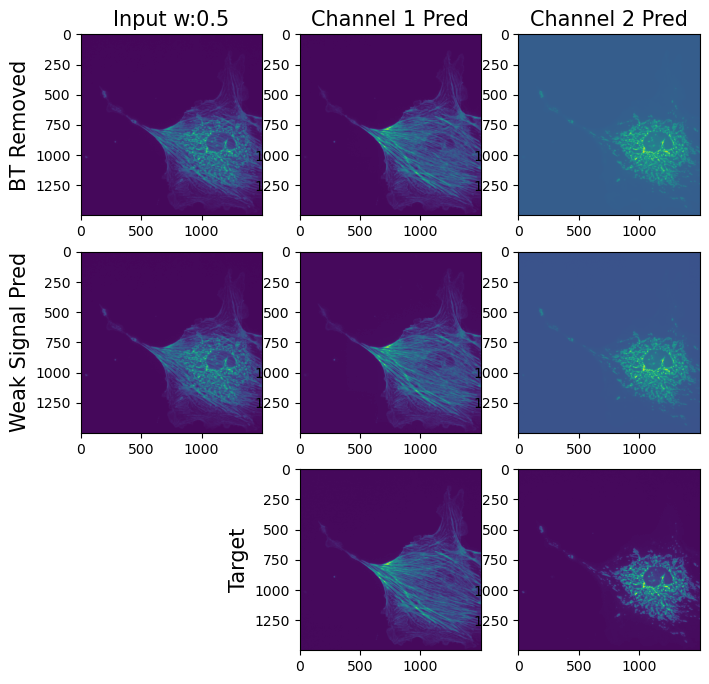

In [25]:
import matplotlib.pyplot as plt

_,ax = plt.subplots(figsize=(8,8),ncols=3,nrows=3)
img_idx = 0
hs = 0 
ws = 0
sz = 1500
# inputs
ax[0,0].set_title(f'Input w:{mixing_t_ood}', fontsize=15)
ax[0,0].imshow(inputs_stitched_ood[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,0].imshow(inputs_stitched_ood[img_idx,hs:hs+sz,ws:ws+sz,1])

#  ch1 predictions
ax[0,1].set_title('Channel 1 Pred', fontsize=15)
ax[0,1].imshow(pred_bt_removed_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,1].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])

# ch2 predictions
ax[0,2].set_title('Channel 2 Pred', fontsize=15)
ax[0,2].imshow(pred_bt_removed_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
ax[1,2].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])

ax[0,0].set_ylabel('BT Removed', fontsize=15)
ax[1,0].set_ylabel('Weak Signal Pred', fontsize=15)

# target
ax[2,0].axis('off')
ax[2,1].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[2,2].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
ax[2,1].set_ylabel('Target', fontsize=15)

In [26]:
import numpy as np

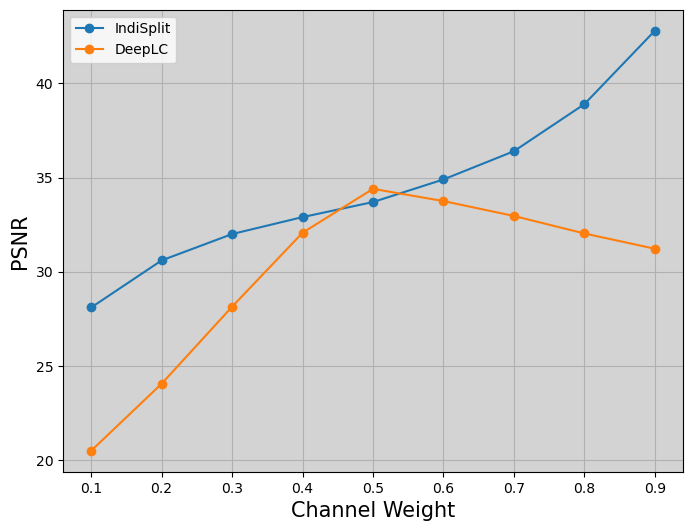

In [27]:
import matplotlib.pyplot as plt

w = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
indisplit = [28.1, 30.6, 32.0, 32.9, 33.7,34.9,36.4, 38.9, 42.8 ]
deepLC = [20.49, 24.05, 28.14, 32.07, 34.4, 33.75, 32.96, 32.03, 31.22]
_,ax = plt.subplots(figsize=(8,6),)
ax.plot(w, indisplit, label='IndiSplit', marker='o')
ax.plot(w, deepLC, label='DeepLC', marker='o')
# add grid
ax.grid()
# background color
ax.set_facecolor('lightgrey')
ax.set_ylabel('PSNR', fontsize=15)
ax.set_xlabel('Channel Weight', fontsize=15)
ax.legend()